<a href="https://colab.research.google.com/github/seank1m/artificial-intelligence-for-robotics/blob/main/Tutorial2_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: K-means Clustering and PCA
In this tutorial, we'll cover unsupervised learning and feature extraction.

Unsupervised learning focuses on learning patterns in unlabelled or untagged data. The algorithm learns the features of the data and their correlations to identify the patterns.
Clustering is a common algorithm used for unsupervised learning, and in this tutorial, we will focus on a commonly used clustering method: k-means clustering.

To improve the accuracy of k-means clustering, the algorithm can be provided with only the important features of the data, thereby reducing the dimensionality of the features. This is specifically important if the data points are high-dimensional. A common approach is to use Principal Component Analysis (PCA), which transforms the original data into a lower dimensional space using linear transforms.

# Setup
Firstly, we'll be generating some toy data to better visualise the problem and algorithms. To visualise the data easily, we will create a set of 2D data points. However, keep in mind that k-means clustering and PCA can both be applied to multi-dimensional data and in the case of PCA, it makes more sense if the data is multi-dimensional (>2).

In [ ]:
#installing libraries that we need to run k-means clustering and PCA
%pip install numpy scipy

#importing the above installed libraries
import numpy as np
import scipy

In [ ]:
#installing libraries that we need to visualize data
%pip install matplotlib plotly

#importing the above installed libraries
from matplotlib import pyplot as plt
from plotly import express as px, graph_objects as go

Let's create a 2D toy dataset. The dataset will have 3 clusters, with each cluster having 100 data points. A data point is represented using its 2D position on the Cartesian $(xy)$ space. Thus, each data point has two features: $x$ position and $y$ position.
We will first define our cluster as an ellipse and later sample 100 points from the ellipses. The formal definition of an ellipse can be written as
$$
\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1 , \text{where  } a \ge b > 0 .\\
$$
Here, $a$ is referred to as the width of the ellipse or the semi-major axis, and $b$ is the height of the ellipse or the semi-minor axis.
The above equation results in an ellipse with its centre at the origin. However, if we want to create three different clusters and shift them to various locations, the centre position needs to be specified.
Thus, below, we define three 2D values for the centre termed mean, three values for $a$ (major), and three values for $b$ (minor).
Additionally, we define three angle values to rotate the clusters.

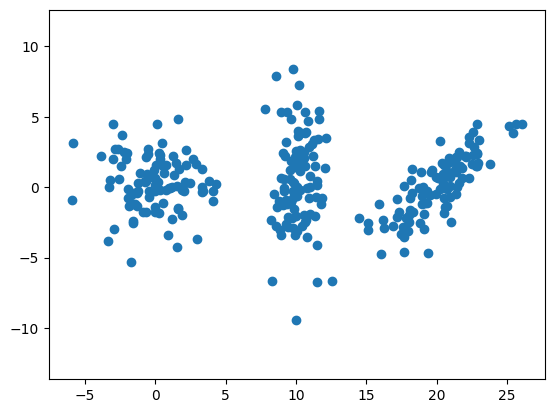

In [ ]:
from math import pi
rng = np.random.default_rng(4)  # the most random number/ the constructor for creating random numbers

n_clusters = 3 # Number of clusters
n_points_per_cluster = 100 # Number of data points per cluster
n_points = n_points_per_cluster * n_clusters # Entire number of data points


# Let's manually assign the following numbers
mean = np.array([[0,0], [10,0], [20,0]]) # Mean 2D position of the 3 clusters
major = np.array([2, 3, 3]) # Semi-major axis of the clusters (a)
minor = np.array([2, 1, 1]) # Semi-minor axis of the clusters (b)
angle = np.array([0, pi/2, pi/4]) # Angle of rotation of the clusters

assert all(minor <= major)

clusters = []
covs = []

for mn, mj, mi, a in zip(mean, major, minor, angle):
    c = np.cos(a) # cos value of the angle
    s = np.sin(a) # sin value of the angle
    R = np.array([
        [c,-s],
        [s, c],
    ]) # 2D rotation matrix as per the specified angle
    D = np.array([
        [mj**2, 0],
        [0, mi**2],
    ]) # Diagonal matrix consisting of major and minor axis values
    cov = R @ D @ R.T # Covariance of the ellipse
    covs.append(cov)
    clusters.append(
        rng.multivariate_normal(
            mn, cov,
            size=n_points_per_cluster,
        ), # Generate 100 random points from a multivariant normal with the specified mean and covariance.
    )

points = np.concatenate(clusters, axis=0) # Concatenate all points in axis o resulting in [300,2] vector.
# Depending on your dataset these points will have the shape of [number of data points, number of features]

# Let's plot the points using scatter function
plt.scatter(points[:,0], points[:,1])
plt.axis('equal')
plt.show()

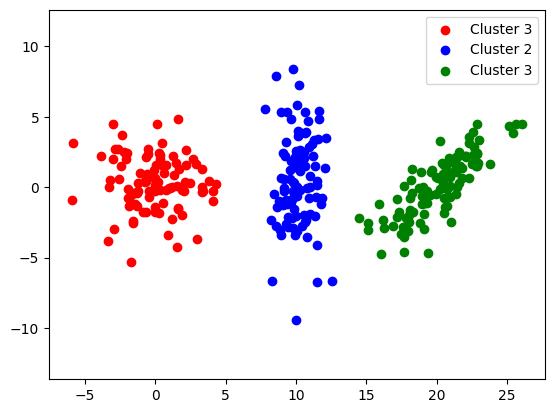

In [ ]:
#Let's visualize each cluster seperately as per generated
plt.scatter(points[:n_points_per_cluster,0], points[:n_points_per_cluster,1], c='r')
plt.scatter(points[n_points_per_cluster:2*n_points_per_cluster,0], points[n_points_per_cluster:2*n_points_per_cluster,1], c='b')
plt.scatter(points[2*n_points_per_cluster:,0], points[2*n_points_per_cluster:,1], c='g')
plt.legend(['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.axis('equal')
plt.show()

# K-Means Clustering
K-means clustering is an unsupervised learning technique which allows the separation of unlabelled data into classes. The number of classes needs to be pre-defined.

## The Algorithm

The algorithm consists of first initialising random points as the centroids of each cluster. Centroids can be initialised by uniformly selecting positions over the domain of the point set, or by randomly selecting points from the point set itself. Importantly, these centroids need not be part of the dataset.

Then, for each point, the Euclidean distance is calculated for each centroid, and the point is assigned to the closest cluster centroid. After going through all the points, the cluster centroids are recalculated as the mean position of all associated points.

This process is iterated till the points are consistently assigned to the same cluster.


In [ ]:
# kmeans function takes 2 arguments: the data points and number of clusters
def kmeans(points, k):
    #_points (array): data points in the shape of [number of data points, number of features]
    # k (int): number of clusters

    # TODO initialise the centroids using rng.choice() function within the domain of the point set
    # IMPORTANT: Two centroids cannot be the same number

    centroids = rng.choice(
        points,
        k,
        replace=False,
    )

    # Assign points to clusters

    # TODO: initialize an array with zeros equivalent to number of points. Each point will have an assignment [0/1/2].
    assignment = np.zeros(points.shape[0]) # The shape of an array is the number of elements in each dimension
    assignment_prev = None
    # TODO write the condition for iteration
    # Tip 1. Starting the assignment
    # Tip 2. When to stop the iteration
    while assignment_prev is None or any(assignment_prev!=assignment):
        assignment_prev= np.copy(assignment) # First keep track of the latest assignment

        # First iterate over all points
        for i, point in enumerate(points):

            # TODO calculate the Euclidean distance (distance2) from each point to the centroids
            # Tip: distance2 should be of length 3
            distances2 = np.linalg.norm(centroids - point, axis=1)
            # TODO calculate the closest centroid for the point
            # Tip: see how np.argmin(...) works
            closest_index = np.argmin(distances2)
            # TODO populate the assignment array with the corresponding centroid
            assignment[i] = closest_index

        # Second calculate new centroids
        for i in range(n_clusters):
            # TODO replace centroids with the mean of points assigned to that centroid
            # Tip: Only select the points assigned to each index value
            centroids[i] = points[assignment == i].mean(axis=0)

    return centroids, assignment

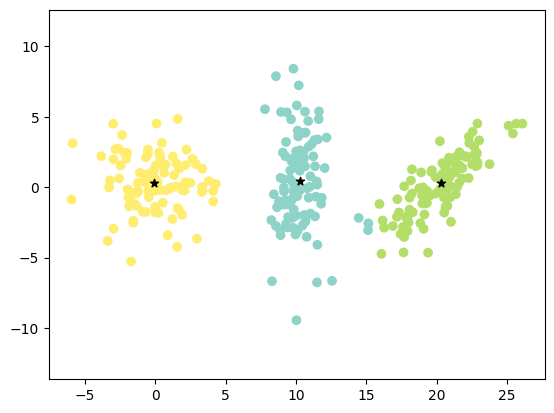

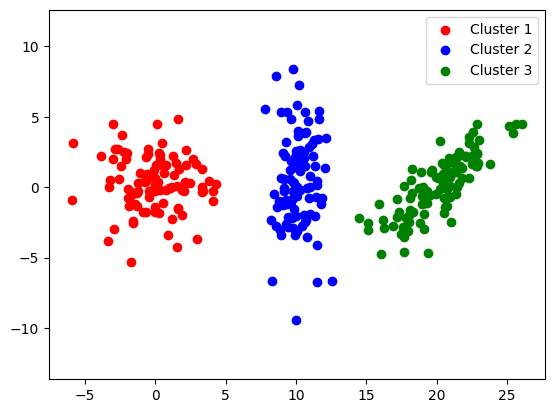

In [ ]:
centroids, clusters = kmeans(points, n_clusters) # calling the k-means algo written above

# Let's plot the clusters
plt.scatter(points[:,0], points[:,1], c=clusters,cmap='Set3')
plt.scatter(centroids[:,0], centroids[:,1], c='k', marker='*')
plt.axis('equal')
plt.show()

# TODO compare this image with the original clusters drawn with red, blue, green. See what points are clustered wrong.
plt.scatter(points[:n_points_per_cluster,0], points[:n_points_per_cluster,1], c='r')
plt.scatter(points[n_points_per_cluster:2*n_points_per_cluster,0], points[n_points_per_cluster:2*n_points_per_cluster,1], c='b')
plt.scatter(points[2*n_points_per_cluster:,0], points[2*n_points_per_cluster:,1], c='g')
plt.legend(['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.axis('equal')
plt.show()

# PCA
As stated in the beginning, PCA is a useful technique to reduce the dimensionality of a dataset with high-dimensional features, which makes it easier to interpret and visualise. It is common to use the first two principal components of the data (further explanation given below) to visualise the data in a 2D space.
To simplify the clustering process, a potential solution is to conduct PCA on a high-dimensional dataset and reduce the feature vectors to a length of 2 and perform clustering on these two features.

Principal components are unit vectors where each unit vector is perpendicular to all other unit vectors (orthonormal). Unit vectors represent the direction of the best-fit lines to the data: give the minimum average squared distance from all the points to the line. Based on these principal components, a change of basis can be performed to transform the data points into a different space.
By only using the first two principal components, the data points can be visualised in 2D space.

The first principal component is in the direction of the most variance of the dataset. You can think of this as the most important feature of the data points.
The second principal component is in the direction of the most variance of the dataset after the first principal component effect is removed. So on and so forth.

Another explanation of the principal components is that they are the eigenvectors of the covariance matrix of the data points. Thus, it is common to use singular value decomposition (SVD) on the data matrix to calculate the principal components. For this tutorial, we will use the inbuilt SVD function from Scipy to calculate PCA.
SVD results in the following

$$
\mathbf{X} = \mathbf{U}\mathbf{\Sigma}\mathbf{W}^T
$$
Here $\mathbf{X}$ is the data matrix of shape $n\times m$.  $\mathbf{\Sigma}$ is a diagonal matrix of shape $n \times m$ with positive numbers called the singular values of $\mathbf{X}$. Both $\mathbf{U}$ ($n\times n$ size) and $\mathbf{W}$ ($m\times m$ size) consist of orthogonal vectors in their columns of length $n$ and $m$, respectively.
$\mathbf{W}$ is also the eigenvectors of $\mathbf{X}^T\mathbf{X}$. Singular values of $\mathbf{X}$ are equivalent to the square root of the eigenvalues of $\mathbf{X}^T\mathbf{X}$ which is equal to $\mathbf{\Sigma}^T\mathbf{\Sigma}$.

In this part of the tutorial, we will calculate the first two principle components of each cluster and draw the corresponding axes to visualise.

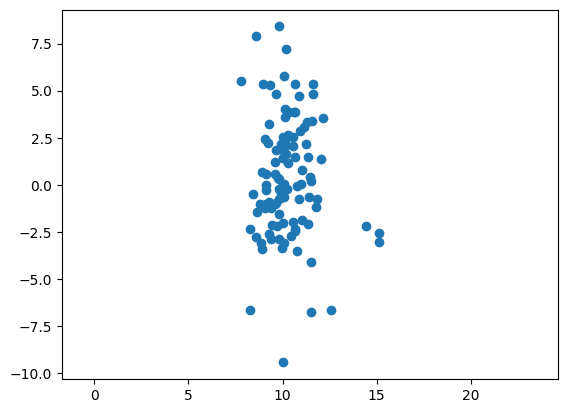

[-7.15716591e-15 -1.55215646e-16]


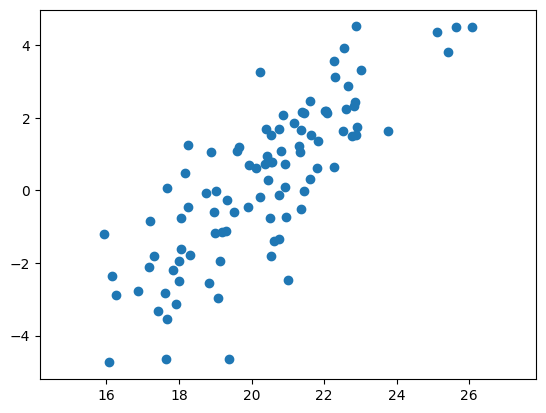

[2.78356948e-15 0.00000000e+00]


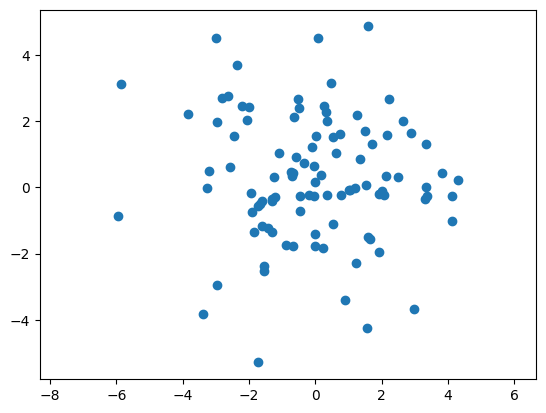

[-7.10542736e-17  9.21485110e-17]


In [ ]:
# import build-in svd calculator
from scipy.linalg import svd


# PCA_algo
def pca(X):
    # X: Data points of a cluster

    # TODO_make sure the data points are centered around their average
    B = X - X.mean(axis=0)

    U, s, Vh = np.linalg.svd(B)

    # TODO_compare U,s,Vh to the above explanation with U, Sigma and W

    U = U[:, :2]      # Select first 2 columns of U (principal component directions)
    s = s[:2]         # Select first 2 singular values (variance explained)
    Vh = Vh[:2, :]    # Select first 2 rows of Vh (eigenvectors of covariance matrix)

    # TODO_calculate the coefficient: principal axes using the eigenvectors and eigenvalues resulted from the SVD
    # Tip 1: use np.diag()
    # Tip 2: remember that the singular values X are equal to the square-root of the eigenvalues XTX.

    coeff= np.diag(s) @ Vh.T
    return coeff


#Plotting the principle axes
for i in range(n_clusters):
    X = points[clusters == i]
    V = pca(X)
    C = np.stack(2*[X.mean(axis=0)]) # Starting to draw the axes at mean location of the cluster.
    plt.scatter(X[:,0], X[:,1])
#     # TODO_read about plt.quiver() and understand the values for the below
    # plt.quiver()
    plt.axis('equal')
    plt.show()
    print(V)

\=\dsdawdawdadLet's do an eigenvalue decomposition of the data covariance matrices of the toy dataset and compare the results to the coefficients of the PCA. For this, we use a built-in function from scipy.linalg.eig()

In [ ]:
print('Eigenvalues and eigen vectors as per eigendecomposition')
for cov in covs:
    vals, vecs = scipy.linalg.eig(cov)
    print(vals[..., None] * vecs)

# TODO_can you explain why the two are different?

Eigenvalues and eigen vectors as per eigendecomposition
[[4.+0.j 0.+0.j]
 [0.+0.j 4.+0.j]]
[[1.000000e+00+0.j 6.123234e-17+0.j]
 [0.000000e+00+0.j 9.000000e+00+0.j]]
[[ 6.36396103+0.j -6.36396103+0.j]
 [ 0.70710678+0.j  0.70710678+0.j]]
